# Аналитика продаж для Яндекс.Афиши

**Автор:** Арина Авиленко  
**Дата:** 07.06.2025

### Цели и задачи проекта

**Цель проекта**  
Провести исследовательский анализ данных сервиса Яндекс Афиша, чтобы выявить изменения в пользовательском спросе, определить факторы, влияющие на активность пользователей в рассматриваемый период, и дать рекомендации продуктовому отделу.

**Задачи проекта**
- Предобработка данных
- Исследовательский анализ данных (EDA)
- Проверка гипотез
- Формулировка выводов и рекомендаций

**Ожидаемые результаты**
- Понимание факторов, влияющих на спрос на мероприятия.
- Выявление сезонных трендов и изменений в пользовательских предпочтениях.
- Определение наиболее прибыльных категорий мероприятий и партнёров.
- Обоснованные рекомендации для продуктового отдела Яндекс Афиши.

### Описание данных

Датасет `final_tickets_orders_df.csv` включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных. 
- `order_id` — уникальный идентификатор заказа.
- `user_id` — уникальный идентификатор пользователя.
- `created_dt_msk` — дата создания заказа (московское время).
- `created_ts_msk` — дата и время создания заказа (московское время).
- `event_id` — идентификатор мероприятия из таблицы events.
- `cinema_circuit` — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- `age_limit` — возрастное ограничение мероприятия.
- `currency_code` — валюта оплаты, например rub для российских рублей.
- `device_type_canonical` — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
- `revenue` — выручка от заказа.
- `service_name` — название билетного оператора.
- `tickets_count` — количество купленных билетов.
- `total` — общая сумма заказа.
- `days_since_prev` - количеством дней с предыдущей покупки для каждого пользователя

Второй датасет `final_tickets_events_df.csv` содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия. 
- `event_id` — уникальный идентификатор мероприятия.
- `event_name` — название мероприятия. Аналог поля event_name_code из исходной базы данных.
- `event_type_description` — описание типа мероприятия.
- `event_type_main` — основной тип мероприятия: театральная постановка, концерт и так далее.
- `organizers` — организаторы мероприятия.
- `region_name` — название региона.
- `city_name` — название города.
- `venue_id` — уникальный идентификатор площадки.
- `venue_name` — название площадки.
- `venue_address` — адрес площадки.

Датасет `final_tickets_tenge_df.csv` содержит информацию о курсе тенге к российскому рублю за 2024 год. 
- `nominal` — номинал (100 тенге).
- `data` — дата.
- `curs` — курс тенге к рублю.
- `cdx` — обозначение валюты (kzt).

## 1. Загрузка данных и знакомство с ними

In [8]:
# Импортируем нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

In [9]:
# Импортируем данные 
try:
    tickets_orders = pd.read_csv(r'C:\Users\arino4ka\Downloads\final_tickets_orders_df.csv')
except:
    tickets_orders = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv')
            
try:
    tickets_events = pd.read_csv(r'C:\Users\arino4ka\Downloads\final_tickets_events_df.csv')
except:
    tickets_events = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')
    
try:
    tickets_tenge = pd.read_csv(r'C:\Users\arino4ka\Downloads\final_tickets_tenge_df.csv')
except:
    tickets_tenge = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

Выводим первые строки загруженных датасетов для знакомства.

In [11]:
tickets_orders.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [12]:
tickets_events.head()

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


In [13]:
tickets_tenge.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


На первый взгляд данные во всех 3-х таблицах выглядят корректно и соответствуют заявленным описаниям.

## 2. Предобработка данных и подготовка их к исследованию

### 2.1. Проверка данных на пропуски и создание объединенного датасета


Далее для более подробного изучения данных выведем для таблиц характеристики с помощью метода `info()`, который позволит оценить число строк, пропуски по столбцам и присвоенные при загрузке типы данных.

In [18]:
tickets_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

In [19]:
tickets_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


In [20]:
tickets_tenge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


Итак, в таблице `tickets_orders` содержится 290 849 строк. Пропуски есть только в столбце `days_since_prev`, что объясняется спецификой самого показателя - это мог быть первый заказ у пользователя. Типы данных в таблице в основном распознаны корректно, однако для столбцов `created_dt_msk` и `created_ts_msk` нужно поменять тип данных на `datetime`. 

Данные в таблице `tickets_events` не содержат пропуски. Всего там 22 427 строк, типы данных присвоены корректно.

Таблица `tickets_tenge` содержит 357 строк, пропусков нет, некорректно распознана дата.


Проведем объединение всех 3-х датасетов прежде, чем начать анализ данных. Таблицы `tickets_afisha` и `tickets_afisha` будем объединять, используя внутреннее соединение. Используется именно этот тип соединения, потому что нам важны данные о событиях в привязке к определенному период, т.е. только те события, билеты на которые были куплены в исторический период с июня по октябрь 2024 года.  
Данные из таблицы `tickets_afisha` присоединим к новому датасету `tickets_afisha` с помощью левого соединения.

In [23]:
tickets_afisha = tickets_orders.merge(tickets_events, on = 'event_id', how = 'inner')
tickets_afisha = tickets_afisha.merge(tickets_tenge, left_on = 'created_dt_msk', right_on = 'data', how = 'left')
tickets_afisha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                290611 non-null  int64  
 1   user_id                 290611 non-null  object 
 2   created_dt_msk          290611 non-null  object 
 3   created_ts_msk          290611 non-null  object 
 4   event_id                290611 non-null  int64  
 5   cinema_circuit          290611 non-null  object 
 6   age_limit               290611 non-null  int64  
 7   currency_code           290611 non-null  object 
 8   device_type_canonical   290611 non-null  object 
 9   revenue                 290611 non-null  float64
 10  service_name            290611 non-null  object 
 11  tickets_count           290611 non-null  int64  
 12  total                   290611 non-null  float64
 13  days_since_prev         268698 non-null  float64
 14  event_name          

Итоговый датасет `tickets_afisha` содержит 28 колонок и 290 611 строк. Пропуски содержатся только в столбце `days_since_prev`.

In [25]:
# Фиксируем начальное количество строк в исходном датасете
initial_rows = tickets_afisha.shape[0]

### 2.2. Преобразование типов данных


Первым делом скорректируем тип данных в столбцах с датой - 'created_dt_msk', 'created_ts_msk' и 'data'.  
Больше никаких преобразований с типами данных делать не будем.

In [28]:
for col in tickets_afisha[['created_dt_msk','created_ts_msk','data']]:
    tickets_afisha[col] = pd.to_datetime(tickets_afisha[col])

In [29]:
tickets_afisha.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,100,18.6972,kzt
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,Каменевский регион,Глиногорск,213,2941,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,100,18.3419,kzt
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,Каменевский регион,Глиногорск,213,4507,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,100,19.6475,kzt
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,Североярская область,Озёрск,2,3574,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,100,18.5010,kzt
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,Озернинский край,Родниковецк,240,1896,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,100,19.6648,kzt


### 2.3. Проверка дубликатов

Проверим новый датасет на явные дубликаты.

In [32]:
tickets_afisha.duplicated().sum()

0

Явных дубликатов нет, попробуем исключить из проверки идентификатор заказа. В данном датасете `order_id` является уникальным значением.

In [34]:
tickets_afisha.columns

Index(['order_id', 'user_id', 'created_dt_msk', 'created_ts_msk', 'event_id',
       'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
       'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev',
       'event_name', 'event_type_description', 'event_type_main', 'organizers',
       'region_name', 'city_name', 'city_id', 'venue_id', 'venue_name',
       'venue_address', 'data', 'nominal', 'curs', 'cdx'],
      dtype='object')

In [35]:
tickets_afisha[['user_id', 'created_dt_msk', 'created_ts_msk', 'event_id',
       'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
       'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev',
       'event_name', 'event_type_description', 'event_type_main', 'organizers',
       'region_name', 'city_name', 'city_id', 'venue_id', 'venue_name',
       'venue_address', 'data', 'nominal', 'curs', 'cdx']].duplicated().sum()

30

Проверка дубликатов по всем полям кроме `order_id` показала наличие 30 дубликатов.
Это значит, что в одно и то же время, с одними и теми же характеристиками, одним и тем же пользователем были совершены одинаковые покупки. Такое маловероятно. Скорее всего такое задвоение могло произойти из-за сбоя системы, поэтому произошло дублирование одного заказа с разными идентификаторами.  
Такие дубли следует удалить.

In [38]:
tickets_afisha = tickets_afisha.drop_duplicates(subset = ['user_id', 'created_dt_msk', 'created_ts_msk', 'event_id',
       'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
       'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev',
       'event_name', 'event_type_description', 'event_type_main', 'organizers',
       'region_name', 'city_name', 'city_id', 'venue_id', 'venue_name',
       'venue_address', 'data', 'nominal', 'curs', 'cdx'])

### 2.4. Добавление столбцов

Для удобства дальнейшего анализа добавим следующие столбцы:

- `revenue_rub` — приведенная к рублям выручка с заказа
- `one_ticket_revenue_rub` — выручка с продажи одного билета на мероприятие
- `month` — месяц оформления заказа
- `season` — столбец с информацией о сезонности ('лето', 'осень', 'зима', 'весна')

In [41]:
# Создаем функцию, которая проверяет валюту и переводит тенге в рубли по актуальному на дату курсу
def convert_to_rub(row):
    if row['currency_code'] == 'kzt':
        return round(row['revenue']/row['nominal'] * row['curs'],2)
    else:
        return row['revenue']
        
# Используем функцию для создания столбца 'revenue_rub'
tickets_afisha['revenue_rub'] = tickets_afisha.apply(convert_to_rub, axis=1)

In [42]:
# Расчет столбца 'one_ticket_revenue_rub'
tickets_afisha['one_ticket_revenue_rub'] = round(tickets_afisha['revenue_rub']/tickets_afisha['tickets_count'],2)

In [43]:
# Расчет столбца 'month'
tickets_afisha['month'] = tickets_afisha['created_dt_msk'].dt.month
tickets_afisha['month'] = tickets_afisha['month'].astype('int8')

In [44]:
# Создаем функцию для определения сезона на дату
def season_def(row):
    if (row['month'] <= 2)|(row['month'] == 12):
        return 'зима'
    elif row['month'] <= 5:
        return 'весна'
    elif row['month'] <= 8:
        return 'лето'
    else:
        return 'осень'

# Расчет столбца 'season'
tickets_afisha['season'] = tickets_afisha.apply(season_def, axis=1)

In [45]:
tickets_afisha['season'].unique()

array(['лето', 'осень'], dtype=object)

Столбцы созданы в соответствии с потребностью.

### 2.5. Проверка значений в ключевых столбцах

#### Категориальные данные

Выведем основную информацию по категориальным столбцам, а также несколько уникальных значений по ним.

In [50]:
def uniques(df, max_unique_values=10):
    object_columns = df.select_dtypes(include=['object']).columns
    
    for col in object_columns:
        unique_values = df[col].unique()
        num_unique = len(unique_values)
        
        print(f"Колонка '{col}':")
        print(f"Количество уникальных значений: {num_unique}")
        
        if num_unique <= max_unique_values:
            print("Уникальные значения:", unique_values)
        else:
            print(f"Первые {max_unique_values} уникальных значений:", unique_values[:max_unique_values])
        
        print("-" * 50)

In [51]:
uniques(tickets_afisha)

Колонка 'user_id':
Количество уникальных значений: 21933
Первые 10 уникальных значений: ['0002849b70a3ce2' '0005ca5e93f2cf4' '000898990054619' '00096d1f542ab2b'
 '000a55a418c128c' '000cf0659a9f40f' '00147c9209d45d3' '0018ecd8a38a51b'
 '00199a573901564' '001e7037d013f0f']
--------------------------------------------------
Колонка 'cinema_circuit':
Количество уникальных значений: 6
Уникальные значения: ['нет' 'Другое' 'Киномакс' 'КиноСити' 'Москино' 'ЦентрФильм']
--------------------------------------------------
Колонка 'currency_code':
Количество уникальных значений: 2
Уникальные значения: ['rub' 'kzt']
--------------------------------------------------
Колонка 'device_type_canonical':
Количество уникальных значений: 2
Уникальные значения: ['mobile' 'desktop']
--------------------------------------------------
Колонка 'service_name':
Количество уникальных значений: 36
Первые 10 уникальных значений: ['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
 'Билеты без проблем' 'Облачко' 

Можно увидеть, что важные для исследования столбцы `currency_code`, `device_type_canonical`, `event_type_main` не содержат дубликатов. Однако следуем для более полной проверки вывести все уникальные значения столбцов `event_type_description` и `region_name`.

In [53]:
tickets_afisha['event_type_description'].sort_values().unique()

array(['балет', 'выставка', 'концерт', 'кукольный спектакль',
       'музыкальный спектакль', 'мюзикл', 'опера', 'оперетта', 'подарок',
       'рок-мюзикл', 'снегурочка', 'событие', 'спектакль', 'спорт',
       'спортивное мероприятие', 'фестиваль', 'цирковое шоу', 'шоу',
       'экскурсия', 'ёлка'], dtype=object)

In [54]:
tickets_afisha['region_name'].sort_values().unique()

array(['Белоярская область', 'Берестовский округ', 'Берёзовская область',
       'Боровлянский край', 'Верховинская область', 'Верхозёрский край',
       'Верхоречная область', 'Ветренский регион', 'Вишнёвский край',
       'Глиногорская область', 'Голубевский округ',
       'Горицветская область', 'Горноземский регион',
       'Горностепной регион', 'Дальнеземская область',
       'Дальнезорский край', 'Дубравная область', 'Залесский край',
       'Заречная область', 'Зеленоградский округ', 'Златопольский округ',
       'Золотоключевской край', 'Зоринский регион', 'Каменевский регион',
       'Каменичская область', 'Каменноозёрный край', 'Каменноярский край',
       'Каменополянский округ', 'Ключеводский округ',
       'Кристаловская область', 'Кристальная область',
       'Крутоводская область', 'Крутоводский регион', 'Лесноярский край',
       'Лесодальний край', 'Лесополянская область', 'Лесостепной край',
       'Лесоярская область', 'Луговая область', 'Лугоградская область',
    

Мы убедились, что в столбцах `event_type_description` и `region_name` нет неявных дубликатов, значения не требуют нормализации.

Подводя итог разделу, важно отметить, что, несмотря на то, что в данных нет null-значений, столбцец с основным типом мероприятия `event_type_main` содержит значение "другое", которое не дает полную информацию о типе мероприятия.

#### Количественные данные

Посмторим теперь на количественные столбцы, а именно на важные для проекта показатели выручки и количества билетов в заказе.

In [58]:
tickets_afisha.groupby('currency_code')['revenue'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99]).transpose()

currency_code,kzt,rub
count,5069.000000,285512.000000
mean,4995.206767,548.036278
std,4916.752776,871.782124
min,0.000000,-90.760000
25%,518.100000,114.190000
50%,3698.830000,346.700000
75%,7397.660000,793.320000
95%,13784.260000,1607.615000
99%,17617.240000,2570.800000
max,26425.860000,81174.540000


Статистика показателей выручки для тенге и рублей показывает:
- Наличие отрицательных значений выручки, что может быть объяснено, например, применением промокодов
- Наличие выбросов в значениях рублевой выручки
- Значительный разброс данных как для выручки в тенге, так и для выручки в рублях. В рублях этот разброс выражен ярче за счет наличия выбросов
- Различие в абсолютных значениях для тенге и рублях

In [60]:
tickets_afisha['revenue_rub'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

count    290581.000000
mean        555.594729
std         875.529615
min         -90.760000
25%         113.970000
50%         351.140000
75%         802.050000
95%        1630.650000
99%        2628.420000
max       81174.540000
Name: revenue_rub, dtype: float64

Оценим разброс выручки уже по новому столбцу с данными, приведенными в рубли. Мы видим, что за счет преобладания наблюдений в рублях, новая стастистика похожа на статистику изначальных продаж в рублях.
Те же выбросы, большое различие среднего и медианы, наличие выбросов сверху.

**Для проведения корректного анализа в будущем, было бы полезно убрать выбросы.**

In [62]:
tickets_afisha['tickets_count'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

count    290581.000000
mean          2.754337
std           1.170614
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
95%           5.000000
99%           6.000000
max          57.000000
Name: tickets_count, dtype: float64

Анализ статистик столбца `tickets_count` показывает чуть более адекватные показатели. Минимум 1, среднее и медиана отличаются, но не так существенно. Стандартное отклонение достаточно большое. Есть выбросы.

Попробуем посмотреть на выбросы для столбцов с вырочкой и количеством билетов в заказе, чтобы аргументировать целесообразность сохранения или отсечения выбросов.

In [65]:
tickets_afisha[['created_dt_msk', 'created_ts_msk', 'event_id',
       'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
       'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev',
       'event_name', 'event_type_description', 'event_type_main', 'organizers',
       'region_name', 'city_name']].loc[tickets_afisha['tickets_count'] > 15].head(3)

,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name
39416,2024-09-09,2024-09-09 10:03:45,561027,нет,12,rub,desktop,640.41,Билеты без проблем,47,32020.47,0.0,a8f27570-50ca-4ff2-9550-8a5493a335a6,спорт,спорт,№4870,Чистогорская область,Леснойск
86271,2024-10-06,2024-10-06 13:08:42,575780,нет,0,rub,desktop,328.49,Лови билет!,27,10949.60,0.0,eaad35f5-f733-4ab1-a671-e7e86b2748c7,спорт,спорт,№4871,Озернинский край,Лесоярич
86274,2024-10-06,2024-10-06 13:06:40,575780,нет,0,rub,desktop,328.49,Лови билет!,27,10949.60,0.0,eaad35f5-f733-4ab1-a671-e7e86b2748c7,спорт,спорт,№4871,Озернинский край,Лесоярич


    Выбросы в столбце с проданными билетами не выглядят как ошибки. Например, у выручки нормальное значение. Мероприятие категории спорт. Вполне вероятно, что на спортивные мероприятия могли закупаться билеты на компанию/класс/спортивную команду.
    Такие значения следует оставить.

In [67]:
tickets_afisha[['created_dt_msk', 'created_ts_msk', 'event_id',
       'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
       'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev',
       'event_name', 'event_type_description', 'event_type_main', 'organizers',
       'region_name', 'city_name']].loc[(tickets_afisha['revenue'] > 10000)&(tickets_afisha['currency_code'] == 'rub')].head(3)

,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name
10817,2024-10-16,2024-10-16 20:10:49,583930,нет,18,rub,mobile,10396.02,Билеты без проблем,4,64975.11,0.0,340e1e70-82b3-4489-9ae6-b8d9d47b5523,шоу,стендап,№3240,Каменевский регион,Глиногорск
10849,2024-10-20,2024-10-20 22:46:15,583930,нет,18,rub,mobile,10396.02,Билеты без проблем,4,64975.11,0.0,340e1e70-82b3-4489-9ae6-b8d9d47b5523,шоу,стендап,№3240,Каменевский регион,Глиногорск
11121,2024-08-06,2024-08-06 12:55:50,552398,нет,16,rub,mobile,48704.72,Облачко,3,487047.22,6.0,b443dc5a-fff2-4b69-8684-0719fff49b59,концерт,концерты,№1277,Североярская область,Озёрск


    Выбросы в столбце с выручкой (оригинальная в рублях) привлекают больше внимания. Требование заказчика было убрать выбросы в выручке по 99-му перцентилю, если они будут вызывать опасения. Так мы и сделаем.

In [69]:
# Фильтруем оригинальный датасет по 99-му перцентилю расчетного столбца 'revenue_rub'
rub_99perc = tickets_afisha['revenue_rub'].quantile(0.99)
tickets_afisha = tickets_afisha.loc[tickets_afisha['revenue_rub'] <= rub_99perc]

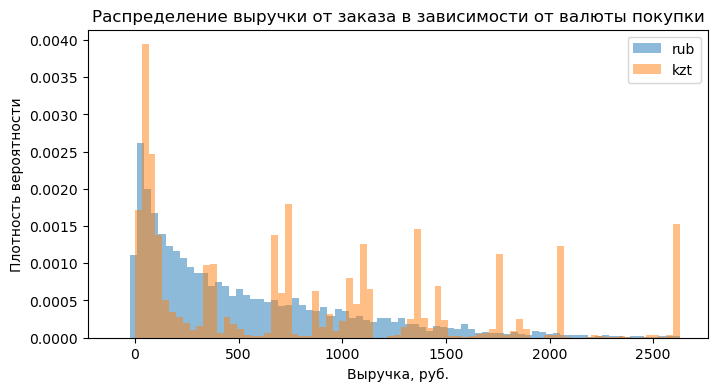

In [70]:
plt.figure(figsize=(8, 4))

for i in tickets_afisha['currency_code'].unique():
    tickets_afisha.loc[tickets_afisha['currency_code'] == i, 'revenue_rub'].plot(
        kind='hist',
        density=True,
        bins=80,
        alpha=0.5,
        label=f'{i}',
        legend=True
    )

# Настраиваем внешний вид графика и выводим его на экран
plt.title(f'Распределение выручки от заказа в зависимости от валюты покупки')
plt.xlabel('Выручка, руб.')
plt.ylabel('Плотность вероятности')
plt.show()

Посмотрим на распределение очищенных от выбросов значений в расчетном столбце `revenue_rub`, где вся выручка приведена к одной валюте, рублям, в разрезе источника данных - продаж в рублях или тенге. 

Распределение в рублях очевидно имеет хвост, скошенный вправо, но выглядит нормально. Значения продаж, осуществленных в тенге выглядит неравномерно, значения концентрируются у отдельных очагов. Скорее всего это объясняется спецификой этого сегмента. Вероятно, российский сервис не настолько распространен в Казахстане, и реализует билеты только на крупные или громкие мероприятия.

### 2.6. Промежуточный вывод

In [73]:
final_rows = tickets_afisha.shape[0]

Сделаем предварительный вывод по предобработке данных. В первую очередь посмотрим, на сколько сократился исходный датасет.

In [75]:
decrease_pp = round((final_rows/initial_rows-1)*100,1)
print(f'Количество строк датафрейма `tickets_afisha` сократилось с {initial_rows} до {final_rows}, в процентах сокращение составило {decrease_pp}%.')
    
    #decrease_pp, final_rows, initial_rows)

Количество строк датафрейма `tickets_afisha` сократилось с 290611 до 287756, в процентах сокращение составило -1.0%.


**Оценка исходных данных**

Данные во всех трёх датасетах (final_tickets_orders_df, final_tickets_events_df, final_tickets_tenge_df) в целом корректны и соответствуют описанию. Пропуски обнаружены только в столбце days_since_prev (объяснимо первыми заказами пользователей). Некорректно распознанные типы данных для дат были скорректированы.

**Объединение данных**

Таблицы успешно объединены с сохранением релевантных данных: orders и events — через inner join (чтобы оставить только события с покупками); добавлен курс тенге через left join для конвертации валют.

Итоговый датасет содержал 290 611 строк и 28 столбцов.

**Очистка данных**

Обнаружены 30 дубликатов (одинаковые заказы с разными order_id), вероятно из-за системного сбоя. Они были удалены. В столбце event_type_main есть категория "другое", которая неинформативна.

**Анализ выбросов**

В данных присутствуют:
- Отрицательная выручка (возможно, из-за промокодов или возвратов).
- Сильные выбросы в revenue и tickets_count (особенно в рублях).
- Для корректного анализа применено отсечение значений выручки по 99-му перцентилю.

**Распределение выручки после очистки:**

***В рублях*** — правосторонняя асимметрия, но без аномалий. ***В тенге*** — неравномерное (вероятно, из-за ограниченного спроса в Казахстане).

Данные очищены и готовы для дальнейшего анализа.

## 3. Исследовательский анализ данных

Приступим к проведению исследовательского анализа данных.

### 3.1. Анализ распределения заказов по сегментам и их сезонные изменения

In [80]:
tickets_afisha.groupby('month')['order_id'].count().reset_index()

,month,order_id
0,6,33903
1,7,40452
2,8,44573
3,9,69415
4,10,99413


Вывод абсолютных значений количества заказов по меясцам показывает прирост на протяжении всего периода. Визуализируем эти показатели.

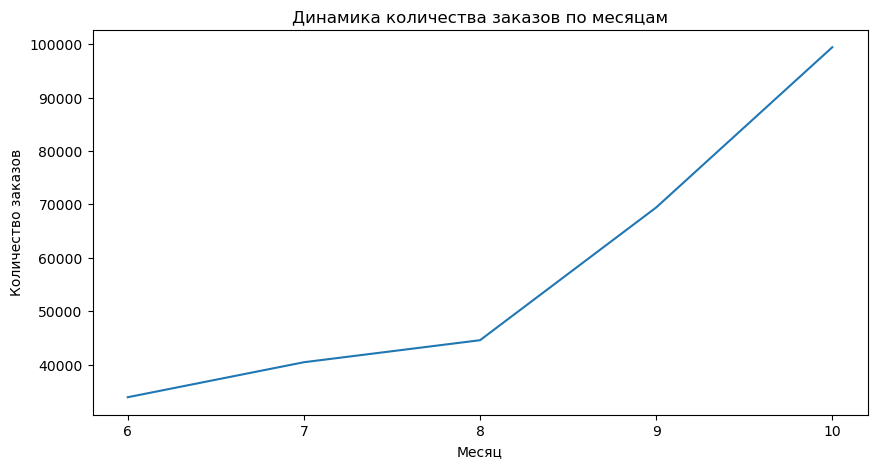

In [82]:
monthly_orders = tickets_afisha.groupby('month')['order_id'].count()

monthly_orders.plot(
    kind='line',
    title='Динамика количества заказов по месяцам',
    ylabel='Количество заказов',
    xlabel='Месяц',
    figsize=(10, 5)
)

plt.xticks(monthly_orders.index, [str(int(month)) for month in monthly_orders.index])
plt.show()

График динамики количества заказов по месяцам подтверждает, что положительный тренд сохраняется на протяжении всего периода, однако скорость прироста числа заказов резко увеличивается в 2 осенних месяца, что говорит о значительном изменении потребительского спроса.

Попробуем более детально посмотреть различие в сезонах для разных категорий.

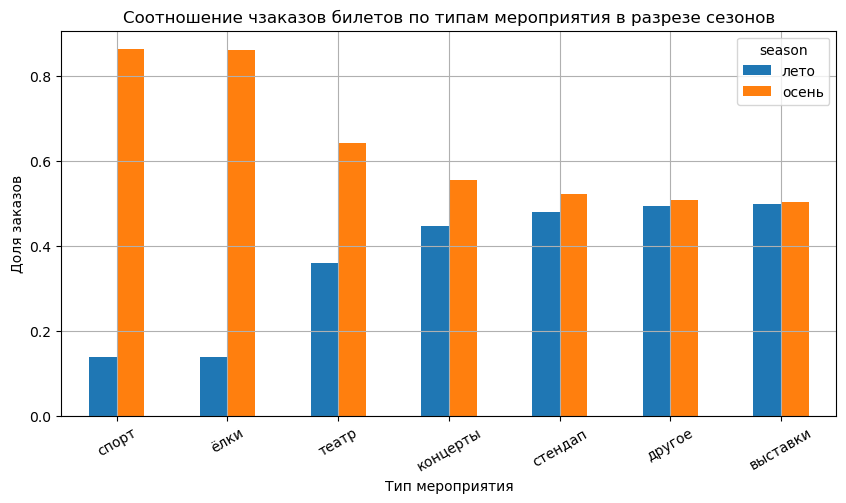

In [84]:
grouped_cat1 = tickets_afisha.groupby('event_type_main')['season'].value_counts(normalize=True).sort_values(ascending=False).unstack(fill_value=0).sort_values(by='осень',
                                                                                                                                                          ascending=False)
grouped_cat1.plot(kind='bar',
               title=f'Соотношение чзаказов билетов по типам мероприятия в разрезе сезонов',
               legend=True,
               ylabel='Доля заказов',
               xlabel='Тип мероприятия',
               rot=30,
               figsize=(10, 5))
plt.grid()

plt.show()

График соотношения числа заказов билетов по сезонам в разрезе типа мероприятия показывает, что наиболее значительные положительные изменения ***внутри категории*** осенью произошли для таких категорий как Спорт, Ёлки и Театр и Концерты. Продажи в категориях Стендап, Другое, Выставки остались практически на том же уровне.
Стоить отметить, что ни в одной из категорий не наблюдается перевеса в заказах в летний сезон, что, возможно, объясняется отпускным сезоном.

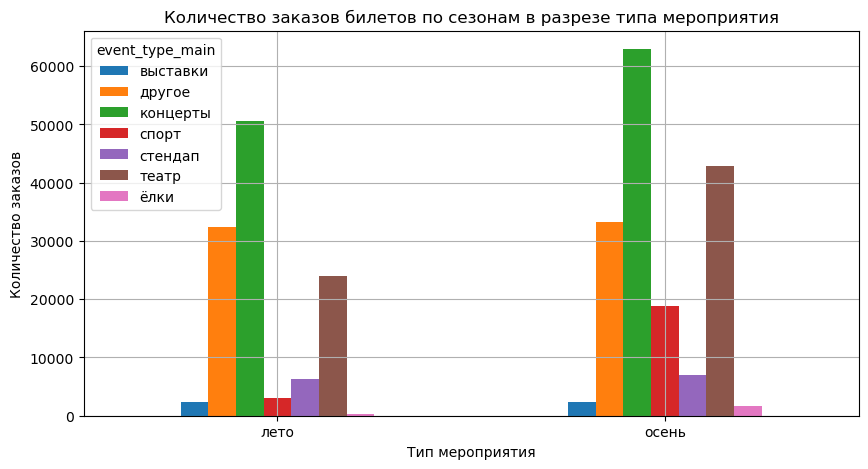

In [86]:
grouped_cat2 = tickets_afisha.groupby(['season', 'event_type_main'])['order_id'].nunique().unstack()
                                                                                                                                                         
grouped_cat2.plot.bar(stacked=False,
               title=f'Количество заказов билетов по сезонам в разрезе типа мероприятия',
               legend=True,
               ylabel='Количество заказов',
               xlabel='Тип мероприятия',
               rot=0,
               figsize=(10, 5))
plt.grid()

plt.show()

Если смотреть на абсолютные значения продаж билетов в категориях по сезонам, то мы находим подтверждение выводам после анализа предыдущего графика. Продажи в категориях Стендап, Другое, Выставки находятся на сопоставимом уровне в разные сезоны.  
Остальные категории показывают прирост разгого уровня. Так, например, в абсолютных начениях наибольший прирост демонстрируют Театры, Спорт и Концерты.

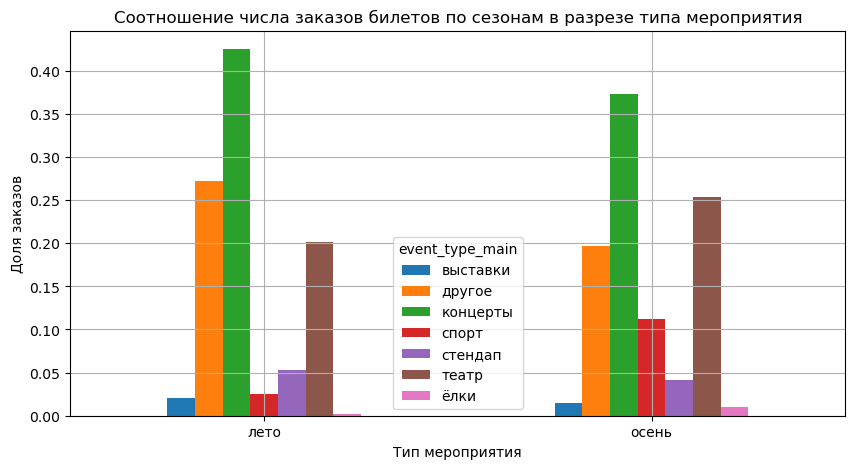

In [88]:
grouped_cat3 = tickets_afisha.groupby(['season', 'event_type_main'])['order_id'].nunique().unstack()
grouped_cat3 = grouped_cat3.div(grouped_cat3.sum(axis=1), axis=0)
                                                                                                                                                         
grouped_cat3.plot.bar(stacked=False,
               title=f'Соотношение числа заказов билетов по сезонам в разрезе типа мероприятия',
               legend=True,
               ylabel='Доля заказов',
               xlabel='Тип мероприятия',
               rot=0,
               figsize=(10, 5))
plt.grid()

plt.show()

Соотношение продаж по категориям также меняется от сезона к сезону. И летом, и осенью лидерами остаются Концерты, Театры и Другие мероприятия, однако осенью доля Концертов и Других мероприятий снижается примерно на 5 процентных пункта. Это снижение долей закономерно следует за счет активного росто продаж в категориях Театров, Спорта, Стендапов и Елок.

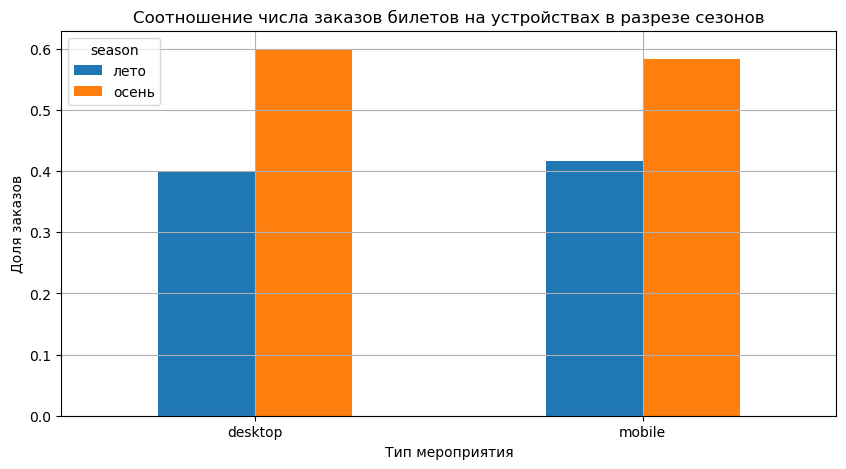

In [90]:
grouped_device1 = tickets_afisha.groupby('device_type_canonical')['season'].value_counts(normalize=True).sort_values(ascending=False).unstack(fill_value=0).sort_values(by='осень',
                                                                                                                                                          ascending=False)
grouped_device1.plot(kind='bar',
               title=f'Соотношение числа заказов билетов на устройствах в разрезе сезонов',
               legend=True,
               ylabel='Доля заказов',
               xlabel='Тип мероприятия',
               rot=0,
               figsize=(10, 5))
plt.grid()

plt.show()

И для мобильных устройств, и для стационарных компьютеров соотношение продаж летом и осень примерно одинаковое 40 на 60%.

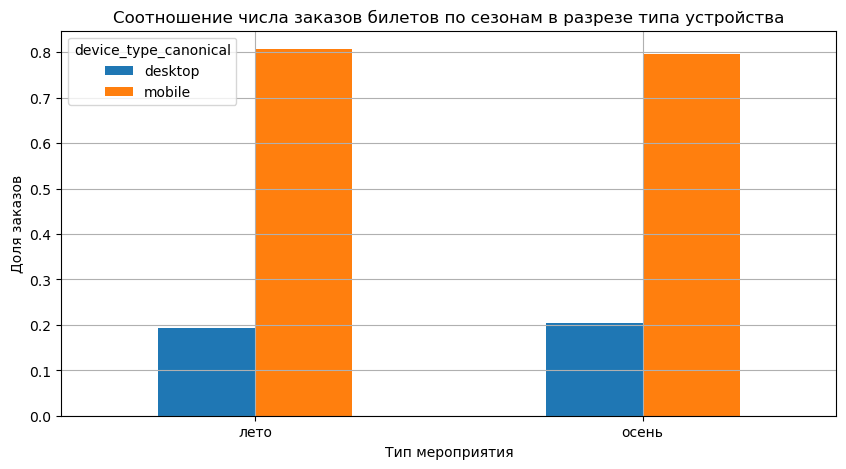

In [92]:
grouped_device2 = tickets_afisha.groupby(['season', 'device_type_canonical'])['order_id'].nunique().unstack()
grouped_device2 = grouped_device2.div(grouped_device2.sum(axis=1), axis=0)
                                                                                                                                                         
grouped_device2.plot.bar(stacked=False,
               title=f'Соотношение числа заказов билетов по сезонам в разрезе типа устройства',
               legend=True,
               ylabel='Доля заказов',
               xlabel='Тип мероприятия',
               rot=0,
               figsize=(10, 5))
plt.grid()

plt.show()

Закономерно, в каждом из сезонов соотношение числа заказов с мобильных и стационарных компьютеров похоже. Осенью процент продаж со стационарного компьютера незначительно повышается.

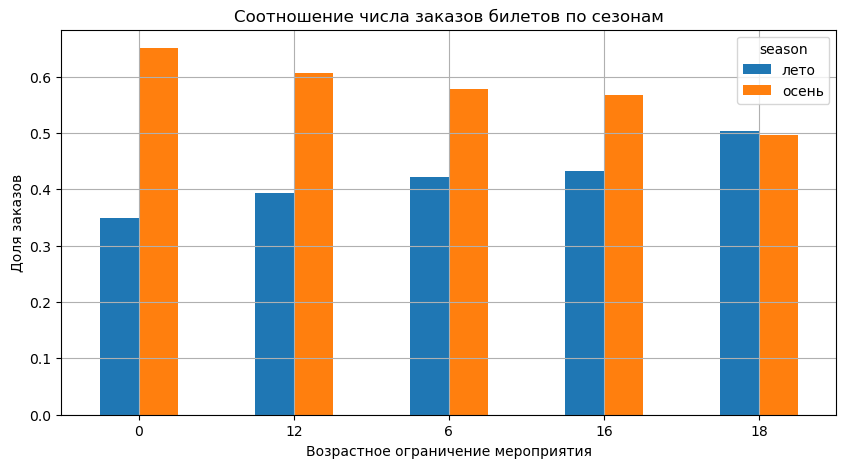

In [94]:
grouped_age1 = tickets_afisha.groupby('age_limit')['season'].value_counts(normalize=True).sort_values(ascending=False).unstack(fill_value=0).sort_values(by='осень',
                                                                                                                                                    ascending=False)
grouped_age1.plot(kind='bar',
               title=f'Соотношение числа заказов билетов по сезонам',
               legend=True,
               ylabel='Доля заказов',
               xlabel='Возрастное ограничение мероприятия',
               rot=0,
               figsize=(10, 5))
plt.grid()

plt.show()

Для мероприятий с ограничениями до 16+ включительно летом продажи ниже, чем осенью. Обратная ситуация с мероприятиями 18+, соотношение продаж по сезонам примерно одинаковое, но на 1-2 процентных пункта продажи осенью ниже, чем летом. Вероятно, летом часто проходят крупные фестивали и вечеринки, что сказывается на статистике продаж билетов в этой категории.

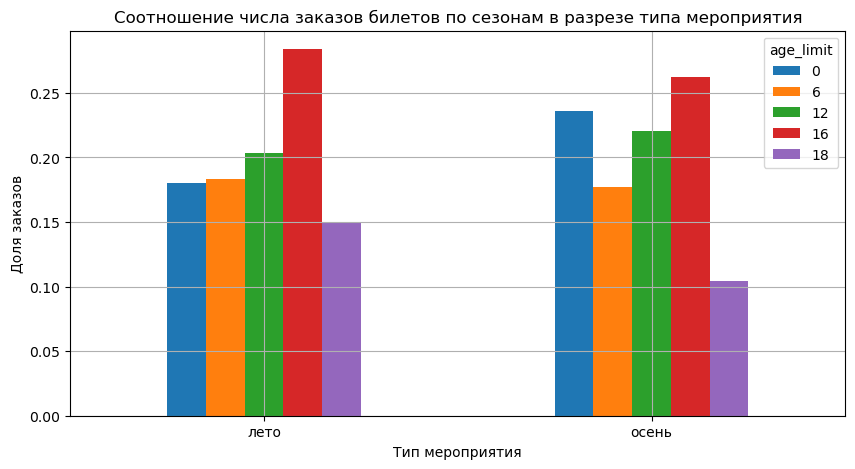

In [96]:
grouped_age3 = tickets_afisha.groupby(['season', 'age_limit'])['order_id'].nunique().unstack()
grouped_age3 = grouped_age3.div(grouped_age3.sum(axis=1), axis=0)
                                                                                                                                                         
grouped_age3.plot.bar(stacked=False,
               title=f'Соотношение числа заказов билетов по сезонам в разрезе типа мероприятия',
               legend=True,
               ylabel='Доля заказов',
               xlabel='Тип мероприятия',
               rot=0,
               figsize=(10, 5))
plt.grid()

plt.show()

На графике соотношение числа заказов билетов по сезонам в разрезе типа мероприятия видно, что осенью чуть выравнивается разрыв между категориями. Если летом лидером по заказам была категория мероприятий 16+, то осенью их доля снижается. Наоборот, доли мероприятий 0+ и 12+ заметно забирают доли.

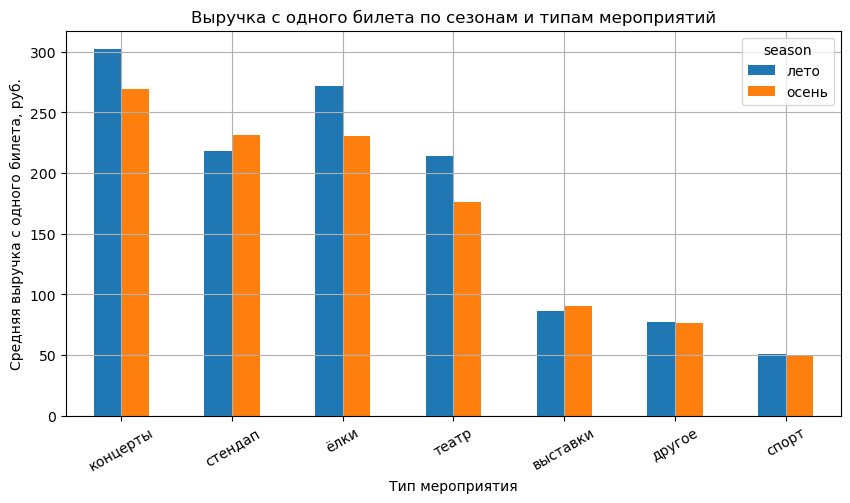

In [98]:
grouped = pd.pivot_table(tickets_afisha,
                             index='event_type_main',
                             columns='season',
                             values='one_ticket_revenue_rub',
                             aggfunc='mean').sort_values(by='осень', ascending=False)

grouped.plot(kind='bar',
               title=f'Выручка с одного билета по сезонам и типам мероприятий',
               legend=True,
               ylabel='Средняя выручка с одного билета, руб.',
               xlabel='Тип мероприятия',
               rot=30,
               figsize=(10, 5))
plt.grid()
plt.show()

In [99]:
grouped['diff_%'] = round((grouped['осень']/grouped['лето'] - 1)*100,1)
display(grouped)


season,лето,осень,diff_%
event_type_main,,,
концерты,302.347772,269.319650,-10.9
стендап,218.585918,231.466943,5.9
ёлки,271.435421,230.309174,-15.2
театр,214.398950,176.231427,-17.8
выставки,86.415530,90.603428,4.8
другое,77.434124,76.115317,-1.7
спорт,50.762242,49.969530,-1.6


Text(0.5, 25.581597222222214, 'Осень VS Лето')

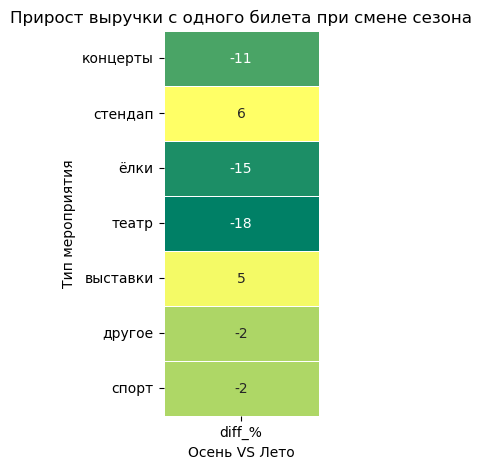

In [100]:
grouped_diff = grouped.reset_index()[['event_type_main','diff_%']].set_index('event_type_main')

plt.figure(figsize=(2, 5))

sns.heatmap(grouped_diff,
            annot=True, 
            fmt='.0f',
            cmap= 'summer',
            linewidths=0.5,
            cbar=False
           )
plt.title('Прирост выручки с одного билета при смене сезона')
plt.ylabel('Тип мероприятия')
plt.xlabel('Осень VS Лето')

Как можно видеть по графикам выше, наибольшее падение средней стоимости билета происходит в категориях Театр, Елки и Концерты. Небольшое падение цены на уровне 2% происходит в категориях Другое и Спорт. А категории Стендап и Выставки осенью приносят больше денег на 5-6% соответственно.

При этом лидерами по выручке с одного билета являются категории Концерты, Стендап, Елки и Театр.

**Вывод**  


С наступлением осени растет спрос на культурные, сезонные (Ёлки) и спортивные мероприятия, при этом средний чек в ключевых категориях (Театр, Концерты, Ёлки) снижается, что может говорить об увеличении числа доступных билетов или изменении структуры предложения. Категории Стендап и Выставки, напротив, становятся дороже, возможно, из-за премиального формата событий в этот период.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Да, можно также заметить, что с июня по октябрь отмечается устойчивый рост количества заказов по различным сегментам. 

### 3.2. Осенняя активность пользователей

Создаем новый датасет `autumn_grouped`, который агрегирует данные по осенним датам.

In [107]:
autumn_grouped = tickets_afisha.loc[tickets_afisha['season'] == 'осень'].groupby('created_dt_msk').agg({
    'order_id': 'count',
    'user_id': 'nunique',
    'one_ticket_revenue_rub': 'mean'
    }).reset_index()

display(autumn_grouped)

,created_dt_msk,order_id,user_id,one_ticket_revenue_rub
0,2024-09-01,1331,565,201.678355
1,2024-09-02,1380,574,189.464739
2,2024-09-03,5114,778,80.502302
3,2024-09-04,1774,686,178.313157
4,2024-09-05,1945,740,189.746026
...,...,...,...,...
56,2024-10-27,2854,1036,187.777120
57,2024-10-28,2841,985,171.113826
58,2024-10-29,2842,999,178.327787
59,2024-10-30,2930,1040,183.224812


Добавляем столбцы с днем недели и меткой выходных.

In [109]:
autumn_grouped['orders_per_user'] = autumn_grouped['order_id']/autumn_grouped['user_id']
autumn_grouped['weekday'] = autumn_grouped['created_dt_msk'].dt.day_of_week + 1
autumn_grouped['weekend'] = autumn_grouped['weekday'].isin([6, 7])
autumn_grouped['weekend'] =autumn_grouped['weekend'].astype('int8')

autumn_grouped = autumn_grouped.set_index('created_dt_msk')
display(autumn_grouped)

,order_id,user_id,one_ticket_revenue_rub,orders_per_user,weekday,weekend
created_dt_msk,,,,,,
2024-09-01,1331,565,201.678355,2.355752,7,1
2024-09-02,1380,574,189.464739,2.404181,1,0
2024-09-03,5114,778,80.502302,6.573265,2,0
2024-09-04,1774,686,178.313157,2.586006,3,0
2024-09-05,1945,740,189.746026,2.628378,4,0
...,...,...,...,...,...,...
2024-10-27,2854,1036,187.777120,2.754826,7,1
2024-10-28,2841,985,171.113826,2.884264,1,0
2024-10-29,2842,999,178.327787,2.844845,2,0


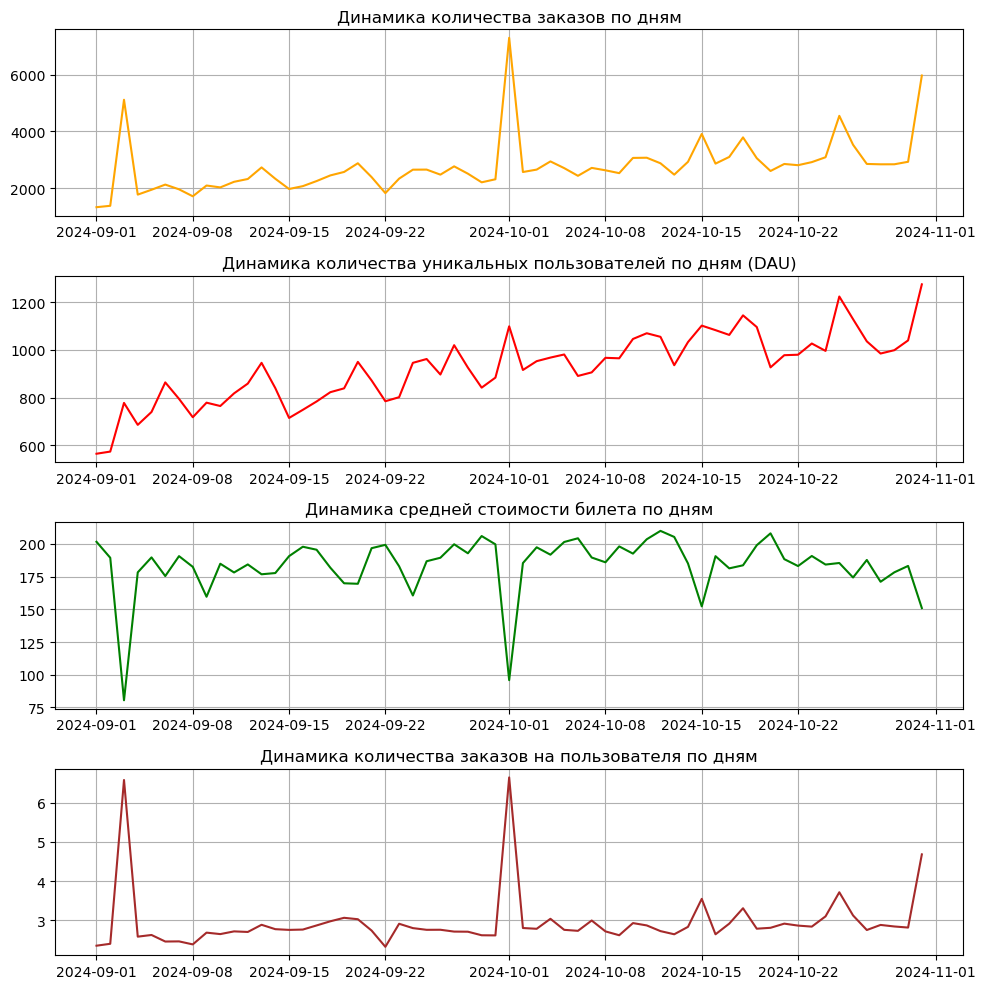

In [110]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 10))  # 4 графика в столбик

# График 1
axes[0].plot(autumn_grouped.index, autumn_grouped['order_id'], color="orange", label="Показатель 1")
axes[0].set_title("Динамика количества заказов по дням")
axes[0].grid(True)

# График 2
axes[1].plot(autumn_grouped.index, autumn_grouped['user_id'], color="red", label="Показатель 2")
axes[1].set_title("Динамика количества уникальных пользователей по дням (DAU)")
axes[1].grid(True)

# График 3
axes[2].plot(autumn_grouped.index, autumn_grouped['one_ticket_revenue_rub'], color="green", label="Показатель 3")
axes[2].set_title("Динамика средней стоимости билета по дням")
axes[2].grid(True)

# График 4
axes[3].plot(autumn_grouped.index, autumn_grouped['orders_per_user'], color="brown", label="Показатель 4")
axes[3].set_title("Динамика количества заказов на пользователя по дням")
axes[3].grid(True)

plt.tight_layout()  # Чтобы подписи не накладывались
plt.show()

По выведенным графикам с динамикой ключевых показателей по дням видно:
 - Есть выбросы в показателях 03.09.2024 и 01.10.2024, что заметно на графиках с динамикой заказов, динамикой средней стоимости билета и динамикой кол-ва заказов на пользователя. Возможно, это связано, со стартом продаж на какое-то крупное мероприятие
 - На всех графиках присутствует сезонность по неделям, пусть и не с совсем точным рисунком
 - На графиках с Динамикой средней стоимости билета по дням и с Динамикой коол-ва заказов на человека отсутствует тренд. Показатели, за исключением выбросов, довольно стабильны
 - На графиках с заказами и уникальными пользователями по дням есть заметный восходящий тренд, особенно заметный на графике с уникальными пользователями

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Осенью 2024 года наблюдается положительная динамика: общее число заказов и количество активных пользователей постепенно увеличиваются. Среднее число заказов на одного пользователя остаётся стабильным, с пиками в отдельные дни. Средняя стоимость билета колеблется, но не демонстрирует чёткой тенденции.

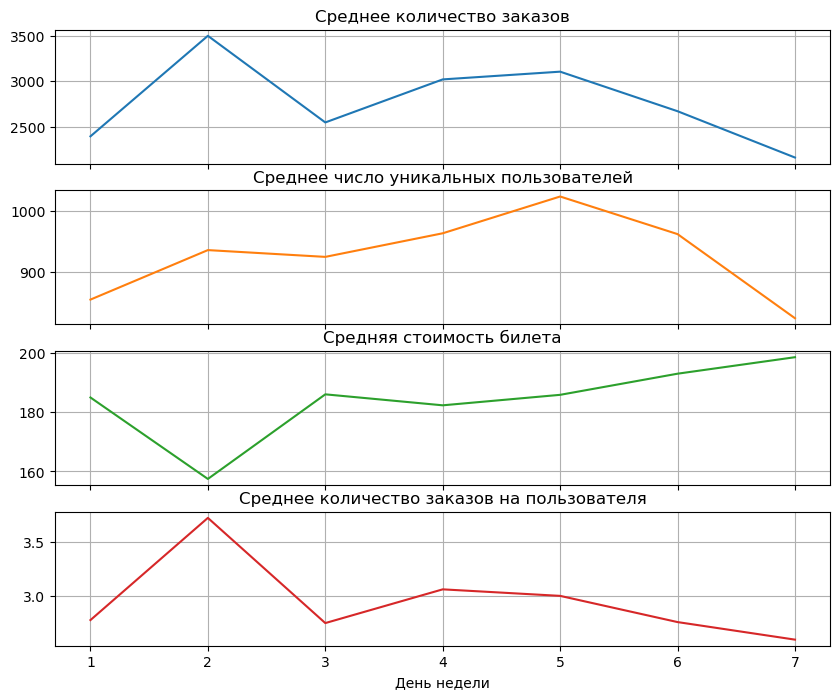

In [113]:
autumn_grouped.groupby('weekday').agg({
    'order_id': 'mean',
    'user_id': 'mean',
    'one_ticket_revenue_rub': 'mean',
    'orders_per_user': 'mean'
}).plot(kind='line',
       subplots=True,
       figsize=(10, 8),
       sharex=True,
       sharey=False,
       grid=True,
       legend=False,
       title=['Среднее количество заказов','Среднее число уникальных пользователей','Средняя стоимость билета','Среднее количество заказов на пользователя'])

plt.xlabel('День недели')
plt.show()
#.reset_index()

In [114]:
autumn_grouped.groupby('weekend').agg({
    'order_id': 'mean',
    'user_id': 'mean',
    'one_ticket_revenue_rub': 'mean',
    'orders_per_user': 'mean'
}).reset_index()

,weekend,order_id,user_id,one_ticket_revenue_rub,orders_per_user
0,0,2910.022727,938.295455,179.118461,3.066461
1,1,2399.235294,888.764706,195.830365,2.675997


По графиком с динамикой показателей *(количество заказов, количество уникальных пользователей, средняя выручка с билета, количество заказов на пользователя)* видно, что 
- в среднем в будни совершается больше заказов, чем в выходные
- в будни больше пользователей совершают заказы
- средняя выручка с билета выше в выходные дни
- в будни больше среднее число билетов на пользователя

**Вывод**  

Пользовательская активность демонстрирует четкую зависимость от дня недели с пиками в будни, но более высокой средней выручкой в выходные. Наличие тренда роста аудитории требует дополнительного анализа причин (например, маркетинговые кампании или расширение ассортимента билетов).

### 3.3. Популярные события и партнёры

#### События

Создадим новую таблицу с группировкой для анализа популярных регионов - `regions_sorted`.

In [120]:
regions_sorted = tickets_afisha.groupby('region_name').agg({
    'event_id': 'nunique',
    'order_id': 'nunique'
}).sort_values(by='event_id', ascending=False) #.reset_index()

display(regions_sorted)

,event_id,order_id
region_name,,
Каменевский регион,5940,89749
Североярская область,3800,43752
Широковская область,1232,16172
Светополянский округ,1075,7502
Речиновская область,702,6268
...,...,...
Теплоозёрский округ,2,7
Сосноводолинская область,2,10
Лесноярский край,2,19


Добавим столбцы 'event_prop' и 'orders_prop', чтобы выделить вклад региона в общее количество событий и заказов.

In [122]:
regions_sorted['event_prop'] = round(regions_sorted['event_id'] / regions_sorted['event_id'].sum(),2)
regions_sorted['orders_prop'] = round(regions_sorted['order_id'] / regions_sorted['order_id'].sum(),2)

regions_sorted.head(25)

,event_id,order_id,event_prop,orders_prop
region_name,,,,
Каменевский регион,5940,89749,0.27,0.31
Североярская область,3800,43752,0.17,0.15
Широковская область,1232,16172,0.06,0.06
Светополянский округ,1075,7502,0.05,0.03
Речиновская область,702,6268,0.03,0.02
Травяная область,683,5036,0.03,0.02
Горицветская область,551,5154,0.02,0.02
Серебринская область,541,5591,0.02,0.02
Яблоневская область,535,6123,0.02,0.02


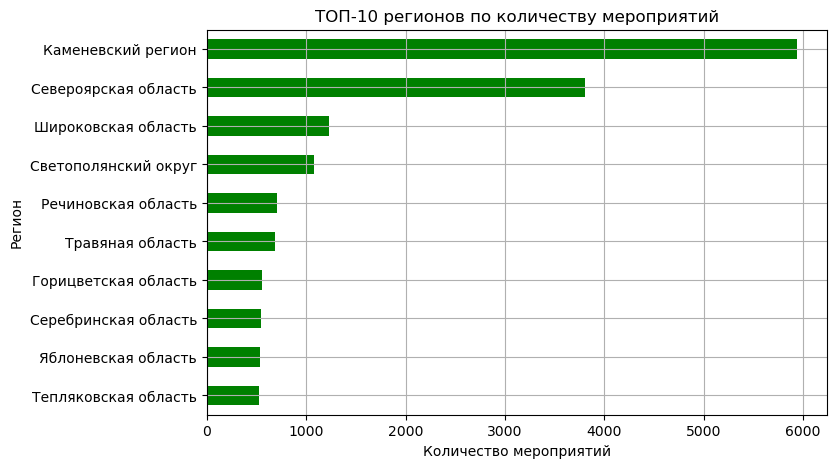

In [123]:
regions_sorted['event_id'].head(10).sort_values().plot(
               kind='barh', 
               rot=0, 
               legend=False, 
               title=f'ТОП-10 регионов по количеству мероприятий',
               figsize=(8, 5),
               color='green'
)

plt.xlabel('Количество мероприятий')
plt.ylabel('Регион')
plt.grid()
plt.show()

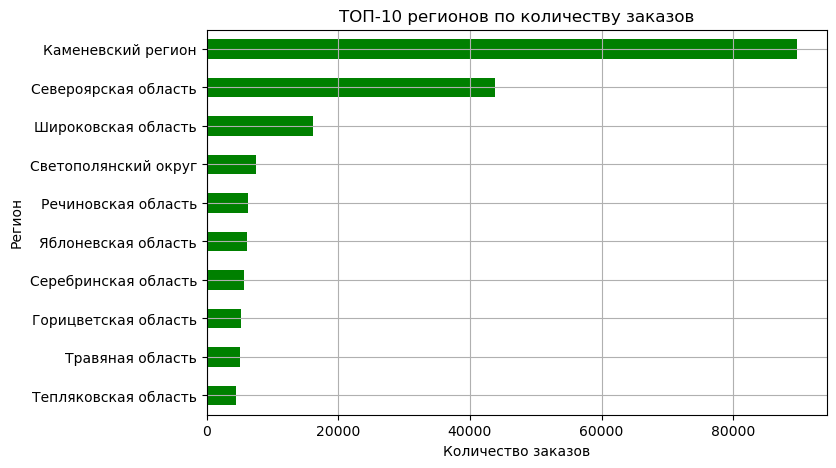

In [124]:
regions_sorted['order_id'].head(10).sort_values().plot(
               kind='barh', 
               rot=0, 
               legend=False, 
               title=f'ТОП-10 регионов по количеству заказов',
               figsize=(8, 5),
               color='green'
)

plt.xlabel('Количество заказов')
plt.ylabel('Регион')
plt.grid()
plt.show()

Как видно по графикам и выведенной таблице, абсолютными лидерами являются Каменевский регион и Североярская область как по количеству мероприятий (27% и 17% соответственно), так и по количеству заказов (31% и 15%). Далее с большим отрывом по обоим показателям следуют Широковская область, Святополянский округ, Речиновская область. Скорее всего это крупные регионы. Закономерно, что при развитой развлекательной индустрии продажи билетов будут соответствующими. 
ТОП-10 и по количеству проводимых мероприятий, и по числу проданных билетов занимают одни и те же регионы.

#### Партнеры

Создадим новую таблицу с группировкой для анализа популярных регионов - `partners_sorted`.

In [128]:
partners_sorted = tickets_afisha.groupby('service_name').agg({
    'event_id': 'nunique',
    'order_id': 'nunique',
    'revenue_rub': 'sum'
}).sort_values(by='event_id', ascending=False) #.reset_index()

partners_sorted.head()

,event_id,order_id,revenue_rub
service_name,,,
Лови билет!,4870,40823,16729886.47
Билеты без проблем,4248,63064,24856575.98
Билеты в руки,3530,40284,13202172.24
Облачко,2335,26410,18609295.34
Лучшие билеты,1762,17741,2724060.58


Аналогично предыдущему разделу, создадим столбцы с долей по столбцам.

In [130]:
partners_sorted['event_prop'] = round(partners_sorted['event_id'] / partners_sorted['event_id'].sum(),2)
partners_sorted['orders_prop'] = round(partners_sorted['order_id'] / partners_sorted['order_id'].sum(),2)
partners_sorted['revenue_prop'] = round(partners_sorted['revenue_rub'] / partners_sorted['revenue_rub'].sum(),2)

display(partners_sorted)

,event_id,order_id,revenue_rub,event_prop,orders_prop,revenue_prop
service_name,,,,,,
Лови билет!,4870,40823,16729886.47,0.20,0.14,0.11
Билеты без проблем,4248,63064,24856575.98,0.17,0.22,0.17
Билеты в руки,3530,40284,13202172.24,0.14,0.14,0.09
Облачко,2335,26410,18609295.34,0.10,0.09,0.12
Лучшие билеты,1762,17741,2724060.58,0.07,0.06,0.02
Мой билет,1300,34139,21062106.80,0.05,0.12,0.14
Тебе билет!,1062,5200,2988324.62,0.04,0.02,0.02
Прачечная,1026,10222,4746810.52,0.04,0.04,0.03
Весь в билетах,856,16438,16566881.11,0.04,0.06,0.11


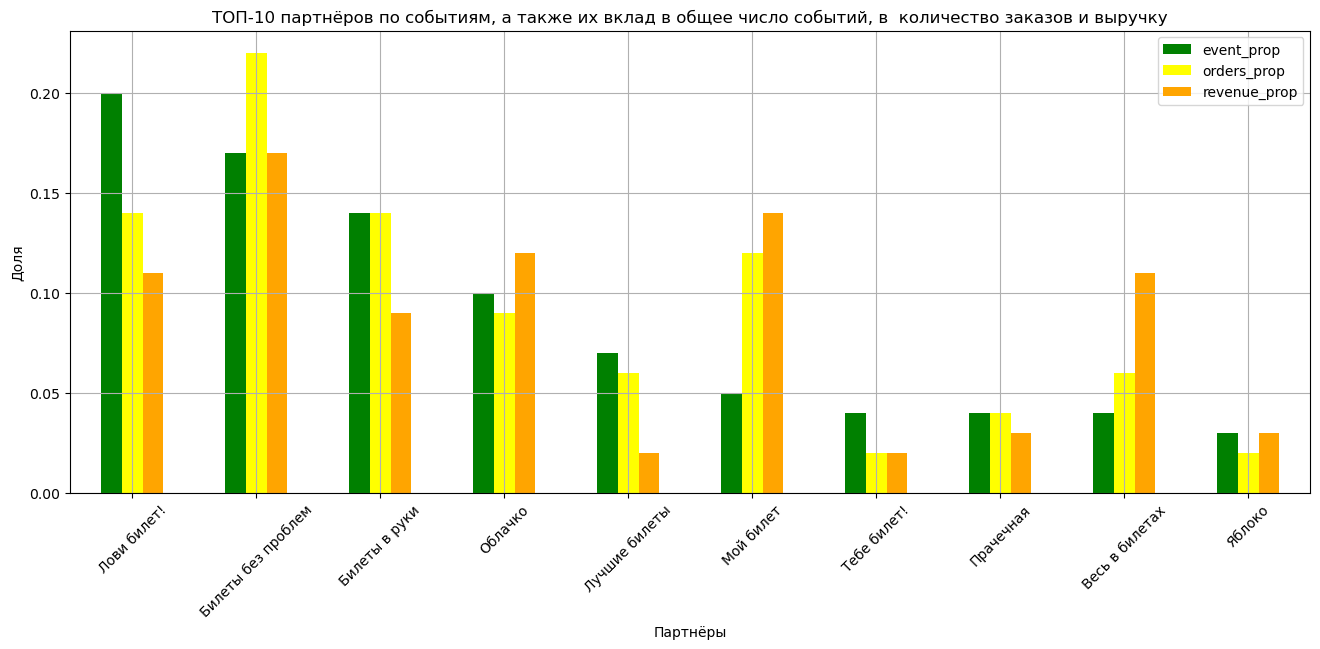

In [131]:
partners_sorted[['event_prop','orders_prop','revenue_prop']].head(10).sort_values(by='event_prop', ascending=False).plot(
               kind='bar', 
               rot=45, 
               legend=True, 
               title=f'ТОП-10 партнёров по событиям, а также их вклад в общее число событий, в  количество заказов и выручку',
               figsize=(16, 6),
               color=['green', 'yellow', 'orange']
)

plt.xlabel('Партнёры')
plt.ylabel('Доля')
plt.grid()
plt.show()

Как видно по таблице и графику, ТОП-10 по парнерам менее согласованный, чем у регионов. Так билетный оператор "Лови билет!", лидирующий по количеству мероприятий, на которые проданы билеты, только второй по доле заказов и доле в выручке. Абсолютным лидером по числу заказов и выручке является партнер "Билеты без проблем".

Аналогично ТОП-10 регионов, среди билетных операторов есть несколько лидеров, которые аккумулируют основную долю заказов, мероприятий, выручки. Вполне возможно, что эти операторы работают в наиболее развитых регионах.

## 4. Статистический анализ данных

### Подготовка данных

Создадим отдельный датасет, оставив только 
- Тип устройства
- Идентификатор пользователя
- Количество заказов
- Среднее количество дней между заказами

In [136]:
users_stat = tickets_afisha.groupby(['device_type_canonical','user_id']).agg({
    'order_id': 'nunique',
    'days_since_prev': 'mean'
}).reset_index()

display(users_stat)

,device_type_canonical,user_id,order_id,days_since_prev
0,desktop,00096d1f542ab2b,1,NaN
1,desktop,00245c702bc343e,1,NaN
2,desktop,0028d17a676f8c8,1,NaN
3,desktop,002b75ca606ba46,4,4.666667
4,desktop,002ec276eee9b0b,1,10.000000
...,...,...,...,...
26802,mobile,ffecf05f1f6a9c6,4,20.000000
26803,mobile,ffed3ff067d4f12,4,26.000000
26804,mobile,fff13b79bd47d7c,9,13.375000
26805,mobile,fffcd3dde79eb2c,26,4.230769


In [137]:
users_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26807 entries, 0 to 26806
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   device_type_canonical  26807 non-null  object 
 1   user_id                26807 non-null  object 
 2   order_id               26807 non-null  int64  
 3   days_since_prev        17624 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 837.8+ KB


Пропуски есть только в столбце days_since_prev, как и должно быть. Всего есть данные о 26 807 наблюдениях.  

Проверим пересечение групп пользователей. Для проведения тестов важно, чтобы данные были независимы.

In [139]:
users_stat['user_id'].duplicated().sum()

4953

Всего 4 953 пользователей совершали покупку и со стационарного компьютера, и с модбльного устройства. Удалим этих пользователей.

In [141]:
users_stat = users_stat.drop_duplicates(subset='user_id', keep=False)

In [142]:
users_stat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16901 entries, 0 to 26806
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   device_type_canonical  16901 non-null  object 
 1   user_id                16901 non-null  object 
 2   order_id               16901 non-null  int64  
 3   days_since_prev        8566 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 660.2+ KB


Остались данные по 16 901 пользователям.

Посмотрим на статистики и визуализацию распределения показателя количества заказов пользователя `order_id`.

In [145]:
users_stat.groupby('device_type_canonical')['order_id'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99]).transpose()

device_type_canonical,desktop,mobile
count,2135.000000,14766.000000
mean,1.962529,2.966206
std,3.149136,3.943026
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,2.000000
75%,2.000000,3.000000
95%,5.000000,9.000000
99%,10.000000,20.000000
max,73.000000,75.000000


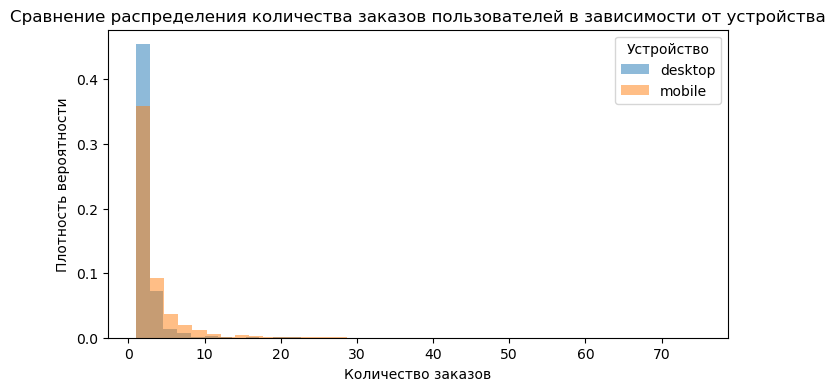

In [146]:
plt.figure(figsize=(8, 4))

for i in users_stat['device_type_canonical'].unique():
    users_stat.loc[users_stat['device_type_canonical'] == i, 'order_id'].plot(
        kind='hist',
        density=True,
        bins=40,
        alpha=0.5,
        label=f'{i}',
        legend=True
    )

# Настраиваем внешний вид графика и выводим его на экран
plt.title(f'Сравнение распределения количества заказов пользователей в зависимости от устройства')
plt.xlabel('Количество заказов')
plt.ylabel('Плотность вероятности')
plt.legend(title='Устройство')
plt.show()

- Есть значительное различие в количестве наблюдений по группам (2135 против 14766)
- В обеих группах есть выбросы
- Оба распределения скошены, имеют правый хвост

Аналогично исследуем столбец `days_since_prev`

In [149]:
users_stat.loc[users_stat['days_since_prev'].notna()].groupby('device_type_canonical')['days_since_prev'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99]).transpose()

device_type_canonical,desktop,mobile
count,802.000000,7764.000000
mean,10.683031,17.059136
std,22.588250,23.943987
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,8.600000
75%,10.625000,23.333333
95%,55.950000,66.500000
99%,122.970000,116.370000
max,146.000000,148.000000


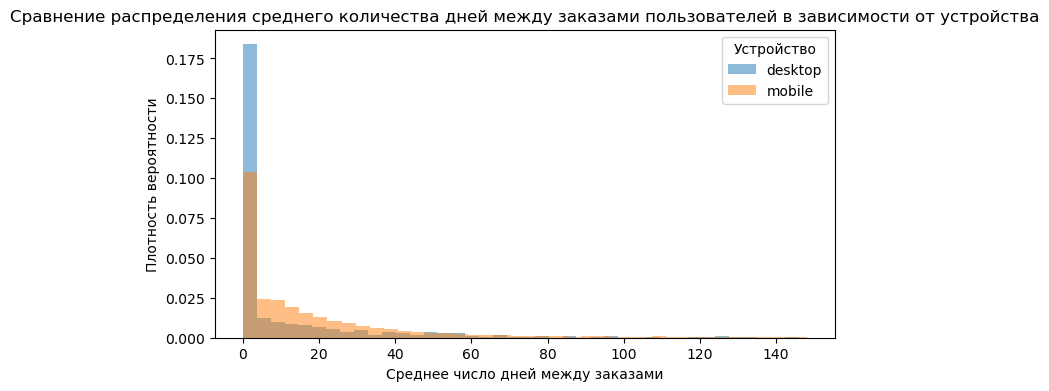

In [150]:
plt.figure(figsize=(8, 4))

for i in users_stat['device_type_canonical'].unique():
    users_stat.loc[(users_stat['device_type_canonical'] == i)&(users_stat['days_since_prev'].notna()), 'days_since_prev'].plot(
        kind='hist',
        density=True,
        bins=40,
        alpha=0.5,
        label=f'{i}',
        legend=True
    )

# Настраиваем внешний вид графика и выводим его на экран
plt.title(f'Сравнение распределения среднего количества дней между заказами пользователей в зависимости от устройства')
plt.xlabel('Среднее число дней между заказами')
plt.ylabel('Плотность вероятности')
plt.legend(title='Устройство')
plt.show()

Распределение числа дней между заказами имеет ту же картину, даже чуть более выраженную
- Есть более значительное различие в количестве наблюдений по группам (802 против 7764)
- В обеих группах есть выбросы
- Оба распределения скошены, имеют тяжелые правые хвост

### Проверка гипотез

**Обоснование выбора теста**

Принимая во внимание, что для обоих исследуемых показателей - `количество заказов`, `среднее количество дней между заказами` - были выделены следующие характеристики распределений:

- Несопоставимое количество наблюдений по группам, явный перевес
- Наличие значимых выбросов
- Не нормальное распределение
- Различие дисперсий

Для проверки ***обеих*** гипотез будет использоваться непараметрический статистический ***тест Манна-Уитни***.

Уровень значимости для проверки обеих гипотез выбираем на уровне 0.05.

**Гипотеза №1**

Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.

- Нулевая гипотеза H₀: Среднее количество заказов на одного пользователя мобильного приложения не выше, чем у пользователей стационарных устройств

- Альтернативная гипотеза H₁: Среднее количество заказов на одного пользователя больше у пользователей мобильных устройств, и это различие статистически значимо.

In [156]:
metric_a = users_stat.loc[users_stat['device_type_canonical'] == 'mobile', 'order_id']

# Сформируйте целевую метрику для группы B
metric_b = users_stat.loc[users_stat['device_type_canonical'] == 'desktop', 'order_id']

# Зафиксируйте уровень значимости
alpha = 0.05

# Проведите тест Манна — Уитни
stat_mw, p_value_mw = mannwhitneyu(
	metric_a,
	metric_b,
	alternative='greater'
)

# Выведите полученное p-value 
print(f'pvalue={p_value_mw}') 

if p_value_mw > alpha: # Напишите условие, на основе которого выбирается наиболее вероятная гипотеза
    print('Нулевая гипотеза находит подтверждение!')
    print(f'У пользователей мобильных устройств среднее количество заказов на одного пользователя не выше, чем у пользователей стационарных устройств')
else:
    print('Нулевая гипотеза не находит подтверждения!')
    print(f'У пользователей мобильных устройств среднее количество заказов на одного пользователя выше, чем у пользователей стационарных устройств')


pvalue=1.9530124614362524e-56
Нулевая гипотеза не находит подтверждения!
У пользователей мобильных устройств среднее количество заказов на одного пользователя выше, чем у пользователей стационарных устройств


**Гипотеза №2**

Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

- Нулевая гипотеза H₀: Среднее время между заказами у пользователей мобильного приложения не выше, чем у пользователей стационарных устройств.

- Альтернативная гипотеза H₁: Среднее время между заказами больше у пользователей мобильных устройств, и это различие статистически значимо.

In [158]:
metric_a = users_stat.loc[(users_stat['device_type_canonical'] == 'mobile')&(users_stat['days_since_prev'].notna()), 'days_since_prev']

# Сформируйте целевую метрику для группы B
metric_b = users_stat.loc[(users_stat['device_type_canonical'] == 'desktop')&(users_stat['days_since_prev'].notna()), 'days_since_prev']

# Зафиксируйте уровень значимости
alpha = 0.05

# Проведите тест Манна — Уитни
stat_mw, p_value_mw = mannwhitneyu(
	metric_a,
	metric_b,
	alternative='greater'
)

# Выведите полученное p-value 
print(f'pvalue={p_value_mw}') 

if p_value_mw > alpha: # Напишите условие, на основе которого выбирается наиболее вероятная гипотеза
    print('Нулевая гипотеза находит подтверждение!')
    print(f'У пользователей мобильных устройств среднее время между заказами не выше, чем у пользователей стационарных устройств')
else:
    print('Нулевая гипотеза не находит подтверждения!')
    print(f'У пользователей мобильных устройств среднее время между заказами выше, чем у пользователей стационарных устройств')


pvalue=1.473432110521076e-48
Нулевая гипотеза не находит подтверждения!
У пользователей мобильных устройств среднее время между заказами выше, чем у пользователей стационарных устройств


**Вывод**  

Проведенный анализ с использованием U-критерия Манна-Уитни показал, что, пользователи мобильного приложения делают больше заказов, чем пользователи стационарных устройств. Интервалы между заказами у мобильных пользователей длиннее, то есть они заказывают реже, но в целом чаще. Это может указывать на разное поведение пользователей в зависимости от типа устройства.

## 5. Общий вывод и рекомендации

**Данные:**  
Исследование проведено на данных Яндекс Афиши (290 611 заказов). После предобработки (удаление дубликатов, обработка выбросов, конвертация валют) данные были готовы для анализа и содержали 287 756 строк.

**Основные результаты:**

Спрос: Наибольший рост заказов осенью в категориях Спорт, Ёлки, Театры, Концерты. Категории Стендап, Выставки, "Другое" остались стабильными.

Средний чек: Снизился в Театрах, Ёлках, Концертах, но вырос в Стендапах и Выставках.

Активность: Пики заказов — в будни, но средний чек выше в выходные. Пользователи мобильных устройств заказывают чаще, но с большими интервалами между заказами.

Регионы и партнёры: Лидеры — Каменевский регион и "Билеты без проблем" (максимум заказов и выручки).

**Проверка гипотез:**

Мобильные пользователи делают больше заказов, но реже, чем пользователи стационарных устройств (подтверждено тестом Манна-Уитни).

**Рекомендации:**
1. Усилить продвижение осенних категорий (Спорт, Ёлки, Театры), особенно в лидирующих регионах.
2. Проанализировать причины снижения среднего чека в ключевых категориях (возможно, из-за увеличения количества бюджетных билетов или из-за маркетинговых акций).
3. Оптимизировать маркетинг под дни недели (активность в будни, премиум-предложения в выходные).
4. Развивать мобильное приложение — его пользователи приносят больше заказов.
5. Изучить успешные практики топ-партнёров ("Билеты без проблем") и топ-регионов для масштабирования.

**Приоритет:**  
Анализ осеннего спроса и стратегия удержания мобильных пользователей.

***Дополнительно:***
Анализ выручки в тенге показал неравномерное распределение с ограниченным спросом по сравнению с рублёвыми продажами. Это может указывать на меньшую активность пользователей из Казахстана или недостаточное покрытие мероприятий в этом регионе. Можно рекомендовать изучить потенциал казахстанского рынка: провести A/B-тесты ценовой политики, расширить ассортимент мероприятий или локализовать маркетинг.